---
author: 
  - name: Matthew Reda
    email: redam94@gmail.com
copyright: 
  holder: Matthew Reda
  year: 2024
citation: true
---

# Optimizer

> Optimizers for models

In [ ]:
#| default_exp optimizer

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
from nbdev.showdoc import *
import matplotlib.pyplot as plt

In [ ]:
#| export
import numpy as np
import pandas as pd
import scipy.optimize as opt

from budget_optimizer.utils.model_classes import BaseBudgetModel
from budget_optimizer.utils.model_helpers import (
  load_module,
  load_yaml,
  BudgetType, 
  AbstractModel
)

from pathlib import Path

In [ ]:
#| export
class Optimizer:
    """Optimizer wrapper for the pyswarms package"""
    _CONFIG_YAML = 'optimizer_config.yaml'
    _MODULE_FILE = "optimizer_config.py"
    
    def __init__(
        self, 
        model: BaseBudgetModel, # The model to optimize
        config_path: str|Path # Path to the configuration files
        ):
        
        self.model: AbstractModel = model
        self._config_path: Path = Path(config_path) if isinstance(config_path, str) else config_path
        self.optimal_budget: BudgetType = None
        self.optimal_prediction: xr.DataArray = None
        self.optimal_contribution: xr.Dataset = None
        self.sol = None
        self._config = self._load_config()
        self._loss_fn = self._load_loss_fn()
        
    def _load_config(self):
        config = load_yaml(self._config_path / self._CONFIG_YAML)
        return config
    
    def reload_config(self):
        self._config = self._load_config()
        return self
    
    def _load_loss_fn(self):
        """Load the loss function from the config file"""
        module = load_module(self._MODULE_FILE.replace(".py", ""), self._config_path / self._MODULE_FILE)
        return module.loss_fn
    
    def _optimizer_array_to_budget(self, array: np.ndarray) -> BudgetType:
        """Convert the optimizer array to a budget"""
        initial_budget: BudgetType = self._config['initial_budget']
        budget: BudgetType = {}
        
        for i, key in enumerate(initial_budget.keys()):
            budget[key] = array[i]
        return budget
    
    def _optimizer_fn(self, x: np.ndarray):
        """Optimizer step"""
        budget = self._optimizer_array_to_budget(x)
        prediction = self.model.predict(budget)
        loss = self._loss_fn(prediction, **self._config['loss_fn_kwargs'])
        return loss
    

    def optimize(self, init_pos: np.ndarray, bounds: list[tuple[float, float]], constraints: None|opt.LinearConstraint = None):
        """Optimize the model"""
        import warnings
        warnings.filterwarnings("ignore")
        self.sol = opt.minimize(
            self._optimizer_fn, init_pos,
            method='trust-constr', 
            bounds=bounds, 
            constraints=constraints
            )
        if not self.sol.success:
            raise Exception(f"Optimization failed: {self.sol.message}")
        
        self.optimal_budget = self._optimizer_array_to_budget(self.sol.x)
        self.optimal_prediction = self.model.predict(self.optimal_budget) # The optimizer minimizes the cost, so we need to negate it
        self.optimal_contribution = self.model.contributions(self.optimal_budget)
        return self

In [ ]:
class BudgetModel(BaseBudgetModel):
    """
    Budget model class
    """
    ...

In [ ]:
m = BudgetModel("Revenue Model", "Revenue", "../example_files/model_1")

In [ ]:
init_budget = np.array([2, 3])
bounds = [(1.8, 2.2), (2.7, 3.3)]
constraints = opt.LinearConstraint([[1, 1]], [5], [5])
o = Optimizer(m, "../example_files")

In [ ]:
o_fitted = o.optimize(init_budget, bounds, constraints)

In [ ]:
o_fitted.sol

           message: `gtol` termination condition is satisfied.
           success: True
            status: 1
               fun: -19.922730394523654
                 x: [ 1.800e+00  3.200e+00]
               nit: 12
              nfev: 24
              njev: 8
              nhev: 0
          cg_niter: 7
      cg_stop_cond: 1
              grad: [-9.233e-01 -1.295e+00]
   lagrangian_grad: [ 7.550e-10 -7.550e-10]
            constr: [array([ 5.000e+00]), array([ 1.800e+00,  3.200e+00])]
               jac: [array([[ 1.000e+00,  1.000e+00]]), array([[ 1.000e+00,  0.000e+00],
                           [ 0.000e+00,  1.000e+00]])]
       constr_nfev: [0, 0]
       constr_njev: [0, 0]
       constr_nhev: [0, 0]
                 v: [array([ 1.294e+00]), array([-3.707e-01,  1.273e-03])]
            method: tr_interior_point
        optimality: 7.549512315210144e-10
  constr_violation: 0.0
    execution_time: 0.05307173728942871
         tr_radius: 3851.3871427543754
    constr_penalty: 1.0
 b

In [ ]:
o_fitted.optimal_budget

{'a': np.float64(1.8004358200580048), 'b': np.float64(3.1995641799419947)}

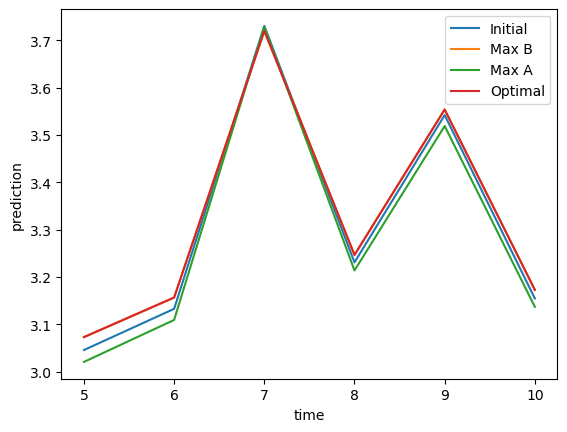

In [ ]:
m.predict({'a': 2, 'b': 3}).sel(time=slice(5, 10)).plot(label="Initial")
m.predict({'a': 1.8, 'b': 3.2}).sel(time=slice(5, 10)).plot(label="Max B")
m.predict({'a': 2.2, 'b': 2.8}).sel(time=slice(5, 10)).plot(label="Max A")
o_fitted.optimal_prediction.sel(time=slice(5, 10)).plot(label="Optimal")
plt.title("Budget Comparison")
plt.legend();

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()